In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
csv_path = 'script_csv/'
male_dialogue = []
female_dialogue = []
for filename in os.listdir(csv_path):
    if filename.endswith('.csv'):
        df = pd.read_csv(csv_path + filename)
        for index, row in df.iterrows():
            if row['gender'] == 'MALE':
                male_dialogue.append(row['line'])
            elif row['gender'] == 'FEMALE':
                female_dialogue.append(row['line'])

print(len(male_dialogue),len(female_dialogue))


10872 2938


In [5]:
csv_iron_man = 'script_csv/iron_man.csv'
male_iron = []
female_iron = []
df = pd.read_csv(csv_path + filename)
for index, row in df.iterrows():
    if row['gender'] == 'MALE':
        male_iron.append(row['line'])
    elif row['gender'] == 'FEMALE':
        female_iron.append(row['line'])
print(len(male_iron),len(female_iron))

622 216


In [48]:
df = pd.read_csv("gender_classifier.csv")
# take only 2 columns gender and tweet
df = df[['gender', 'text']]
df.head()
print(df['gender'].value_counts())

gender
female     6700
male       6194
brand      5942
unknown    1117
Name: count, dtype: int64


In [49]:
def clean_test(text):
    # remove all non-ascii characters
    # remove all the specials characters
    special_chars = "!#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    for i in text:
        if i in special_chars:
            text = text.replace(i, ' ')
    return ''.join([i if ord(i) < 128 else ' ' for i in text])

df['text'] = df['text'].apply(clean_test)
df.head()

,gender,text
0,male,Robbie E Responds To Critics After Win Against...
1,male,It felt like they were my friends and I was...
2,male,i absolutely adore when louis starts the songs...
3,male,Hi JordanSpieth Looking at the url do you...
4,female,Watching Neighbours on Sky catching up with t...


In [50]:
# replace male by 0 and female by 1
df['gender'] = df['gender'].map({'female': 1, 'male': 0})



In [51]:
df.head()

,gender,text
0,0.0,Robbie E Responds To Critics After Win Against...
1,0.0,It felt like they were my friends and I was...
2,0.0,i absolutely adore when louis starts the songs...
3,0.0,Hi JordanSpieth Looking at the url do you...
4,1.0,Watching Neighbours on Sky catching up with t...


In [52]:

df = df.dropna()
print(df['gender'].value_counts())
print(df.shape)

gender
1.0    6700
0.0    6194
Name: count, dtype: int64
(12894, 2)


In [53]:

import numpy as np
import pandas as pd
import string
import re
# import traintestsplit
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, RobertaModel, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm import tqdm
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertForSequenceClassification

In [54]:
tokenizer = AutoTokenizer.from_pretrained('Bert-base-uncased')
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #bertforsequenceclassification
        self.bert = AutoModel.from_pretrained('Bert-base-uncased')
        self.fc = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask)
        x = x['pooler_output']
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
    
class TwitterDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.iloc[idx]['text']
        label = self.df.iloc[idx]['gender']

        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label)
        }

In [55]:
# split df into train and test
train_df, test_df = train_test_split(df, test_size=0.2)

In [56]:
train_dataset = TwitterDataset(train_df, tokenizer, 256)
test_dataset = TwitterDataset(test_df, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2)

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 5


cpu


Some weights of the model checkpoint at Bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
def train(model, train_loader, test_loader, num_epochs, criterion, optimizer):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            label = data['label'].to(device)   
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            outputs = outputs.squeeze()
            print(outputs)
            loss = criterion(outputs, label.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss/len(train_loader)}')
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            y_true = []
            y_pred = []
            for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
                input_ids = data['input_ids'].to(device)
                attention_mask = data['attention_mask'].to(device)
                label = data['label'].to(device)
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, label.float())
                running_loss += loss.item()
                y_true.extend(label.cpu().numpy())
                y_pred.extend(outputs.cpu().numpy())
            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            y_pred = np.round(y_pred)
            #compute f1 scores for each all 4 columns
            f1 = f1_score(y_true, y_pred)
            print(f'Loss: {running_loss/len(test_loader)}')

In [59]:
train(model, train_loader, test_loader, num_epochs, criterion, optimizer)


  0%|          | 0/5158 [00:00<?, ?it/s]

tensor([0.5561, 0.5523], grad_fn=<SqueezeBackward0>)


  0%|          | 1/5158 [00:04<6:05:27,  4.25s/it]

tensor([0.5571, 0.5964], grad_fn=<SqueezeBackward0>)


  0%|          | 2/5158 [00:08<5:56:25,  4.15s/it]

tensor([0.5507, 0.5640], grad_fn=<SqueezeBackward0>)


  0%|          | 3/5158 [00:12<5:43:26,  4.00s/it]

tensor([0.5540, 0.5803], grad_fn=<SqueezeBackward0>)


  0%|          | 4/5158 [00:15<5:27:19,  3.81s/it]

tensor([0.5891, 0.5788], grad_fn=<SqueezeBackward0>)


  0%|          | 5/5158 [00:19<5:28:18,  3.82s/it]

tensor([0.5413, 0.5691], grad_fn=<SqueezeBackward0>)


  0%|          | 6/5158 [00:22<5:16:10,  3.68s/it]

tensor([0.5615, 0.5734], grad_fn=<SqueezeBackward0>)


  0%|          | 6/5158 [00:25<6:08:22,  4.29s/it]


KeyboardInterrupt: 

In [ ]:
model = Model().to(device)
model.load_state_dict(torch.load('model.pth'))
# freeze roberta layers and just train the linear head

for param in model.bert.parameters():
    param.requires_grad = False

def fine_tune():
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    train(model, train_loader, test_loader, num_epochs, criterion, optimizer)
    torch.save(model.state_dict(), 'model_finetuned.pth')
    




In [ ]:
movies = []
f1 = []
ac = []

# plot the f1 and acc as lines for each movie
plt.plot(movies, f1, label='f1')
plt.plot(movies, ac, label='accuracy')
# put movie on x-axis
plt.xlabel('Movie')
plt.ylabel('F1 and Accuracy')
# roatate the x-axis labels
plt.xticks(rotation=90)
plt.legend()

plt.show()


In [2]:
import matplotlib.pyplot as plt

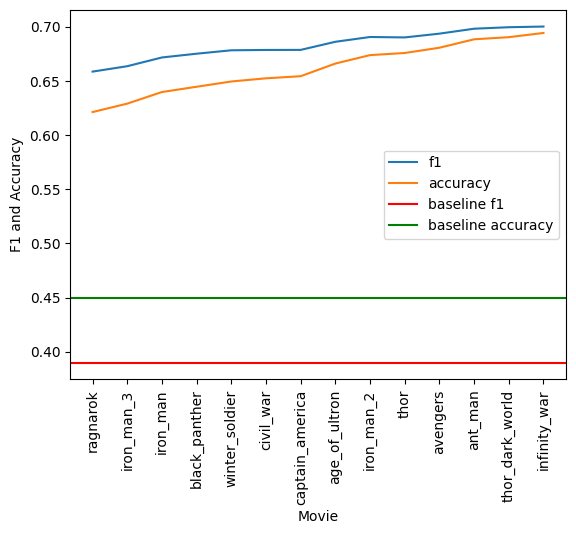

In [3]:
movies = [
    "ragnarok",
    "iron_man_3",
    "iron_man",
    "black_panther",
    "winter_soldier",
    "civil_war",
    "captain_america",
    "age_of_ultron",
    "iron_man_2",
    "thor",
    "avengers",
    "ant_man",
    "thor_dark_world",
    "infinity_war"
]
f1_scores = [
    0.658576093485588,
    0.6635661118460366,
    0.6716302665528565,
    0.6751101607232507,
    0.6782597666629863,
    0.6785642612511992,
    0.6786234317580395,
    0.6861080570855859,
    0.6905331171432457,
    0.6901336833667766,
    0.6936173453719896,
    0.6981775575066561,
    0.6995566125254691,
    0.7001732978404557
]
accuracies = [
    0.6212268743914313,
    0.629016553067186,
    0.6397273612463485,
    0.6445959104186952,
    0.6494644595910418,
    0.6523855890944499,
    0.6543330087633885,
    0.6660175267770204,
    0.6738072054527751,
    0.6757546251217137,
    0.6806231742940604,
    0.688412852969815,
    0.6903602726387537,
    0.6942551119766309
]

baseline_f1 = 0.39
baseline_accuracy = 0.45


plt.plot(movies, f1_scores, label='f1')
plt.plot(movies, accuracies, label='accuracy')
plt.axhline(y=baseline_f1, color='r', linestyle='-', label='baseline f1')
plt.axhline(y=baseline_accuracy, color='g', linestyle='-', label='baseline accuracy')
plt.xlabel('Movie')
plt.ylabel('F1 and Accuracy')
plt.xticks(rotation=90)
plt.legend()
plt.show()
